In [1]:
import os
import random
import numpy as np
import yfinance as yf
import pandas as pd
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from matplotlib import pyplot as plt
np.random.seed(107)
%matplotlib inline
import numpy as np

# Test for cointegration

In [2]:
stocks = ["GOOG", "MSFT", "AAPL", "TSLA", "META", "NFLX"]
start_date = "2023-04-01"
end_date = "2023-05-31"
df = yf.download(stocks, start = start_date, end = end_date)["Adj Close"]
df.head()

[*********************100%***********************]  6 of 6 completed


,AAPL,GOOG,META,MSFT,NFLX,TSLA
Date,,,,,,
2023-04-03,165.940475,104.910004,213.070007,286.603485,348.279999,194.770004
2023-04-04,165.401230,105.120003,214.720001,286.553558,346.750000,192.580002
2023-04-05,163.533798,104.949997,211.479996,283.719757,342.350006,185.520004
2023-04-06,164.432556,108.900002,216.100006,290.963928,339.329987,185.059998
2023-04-10,161.806183,106.949997,214.750000,288.758759,338.989990,184.509995


In [3]:
from itertools import combinations

stock_pairs  = list(combinations(df.columns, 2))

# Cheking cointegrating based on p value

In [4]:
threshold = 0.05
for pair in stock_pairs:
    df2 = df[list(pair)]
    
    score, pvalue, _ = coint(df2.values[:,0], df2.values[:,1])
    if pvalue < threshold:
        print(pair, " are cointegrated")
    else:
        print(pair, ' are not cointegrated')
    
    

('AAPL', 'GOOG')  are not cointegrated
('AAPL', 'META')  are not cointegrated
('AAPL', 'MSFT')  are cointegrated
('AAPL', 'NFLX')  are not cointegrated
('AAPL', 'TSLA')  are not cointegrated
('GOOG', 'META')  are not cointegrated
('GOOG', 'MSFT')  are not cointegrated
('GOOG', 'NFLX')  are not cointegrated
('GOOG', 'TSLA')  are not cointegrated
('META', 'MSFT')  are cointegrated
('META', 'NFLX')  are not cointegrated
('META', 'TSLA')  are not cointegrated
('MSFT', 'NFLX')  are not cointegrated
('MSFT', 'TSLA')  are not cointegrated
('NFLX', 'TSLA')  are not cointegrated


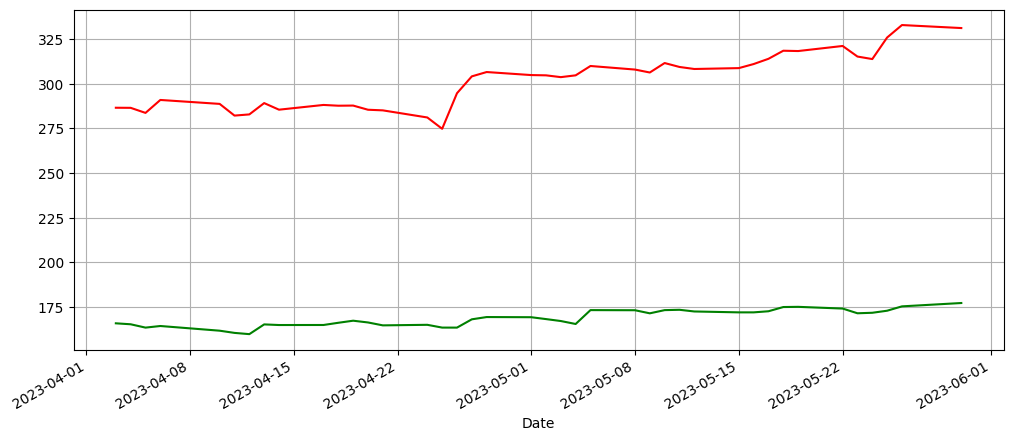

In [5]:
plt.figure(figsize=(12,5))
ax1 = df["AAPL"].plot(color="green", grid = True, label = "AAPL")
ax2 = df["MSFT"].plot(color="red", grid = True, label = "MSFT")
plt.show()


# Since the series is non stationary so we will use Engle-granger test to identify the residual of spread of these two assets and test for cointegration and spread is supposed to be stationary

In [6]:
ap = pd.Series(df["AAPL"], name = "apple")
ms = pd.Series(df["MSFT"], name = "micro")
Score, p_value, _ = coint(ap, ms)
correlation = ap.corr(ms)
print("correlation between AAPLE and MSFT is %f" % correlation)
print("cointegration between AAPLE and MSFT is %f" % p_value)

correlation between AAPLE and MSFT is 0.908075
cointegration between AAPLE and MSFT is 0.042860


In [7]:
def stationary(x, threshold = 0.5):
    pvalue = adfuller(x)[1]
    if pvalue < threshold:
        return 'p-value is ' + str(pvalue) + '.This series is likely stationary'
    else:
        return 'p-value is ' + str(pvalue) + '.This series is likely non stationary'

In [8]:
print(stationary(df["AAPL"]))
print(stationary(df["MSFT"]))

p-value is 0.9025771569787273.This series is likely non stationary
p-value is 0.9174450333229187.This series is likely non stationary


# Normalize the data as the stock have different price scale and comparing the percentage change in price

In [9]:
def normalize(data):
    return data.pct_change()

micro_percentage_chnge = pd.Series(normalize(ms), name = "pct_c")
apple_percentage_chnge = pd.Series(normalize(ap), name = "pct_c")

In [10]:
micro_percentage_chnge = micro_percentage_chnge.tail(len(micro_percentage_chnge)-1)
apple_percentage_chnge = apple_percentage_chnge.tail(len(apple_percentage_chnge)-1)

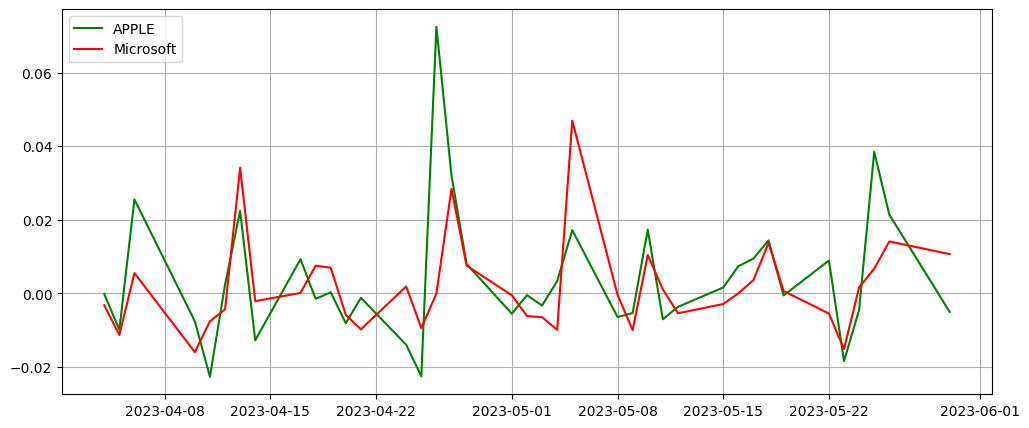

In [11]:
fig, ax  = plt.subplots(figsize = (12,5))
plt.plot(micro_percentage_chnge, color = "green", label = "APPLE")
plt.plot(apple_percentage_chnge, color = "red", label = "Microsoft")
ax.grid(True)
plt.legend(loc= 2)
plt.show()

# using the independent predictor to predict the target variable 

## stock X price is getting constant using linear regression model and than residual(spread)

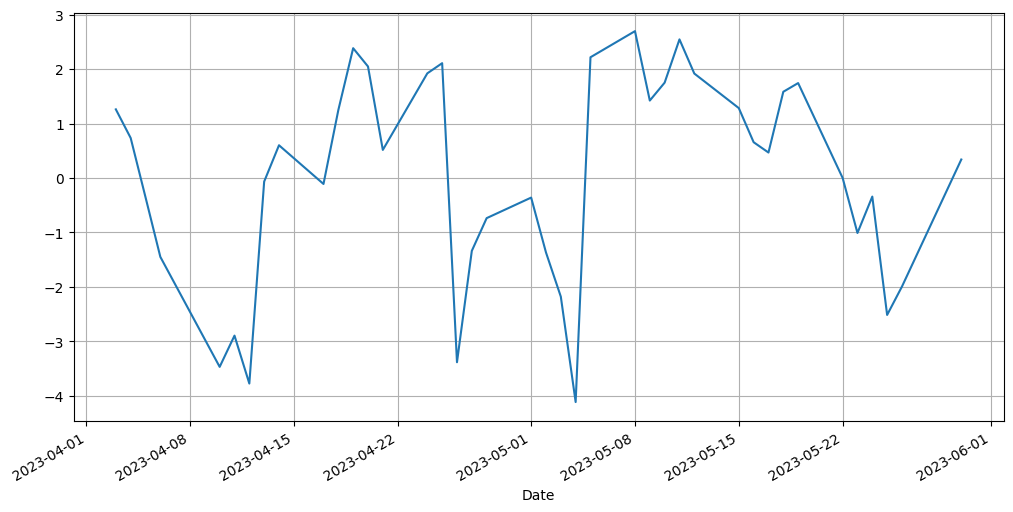

In [12]:
Y = df["AAPL"]
X = df["MSFT"]
# estimate linear regression coefficient
X_with_constant = sm.add_constant(X)
model = OLS(Y, X_with_constant).fit()
# spread as a residual
spread = Y - model.predict()
spread.plot(figsize=(12,6))
plt.grid(True)

In [13]:
stationary(spread)

'p-value is 0.012731579920601949.This series is likely stationary'

#### As the stock spread it is difficult to understand a big deviatation as stock price have differrent scales, so standarlize the z score

# converting to z scores

<Axes: xlabel='Date'>

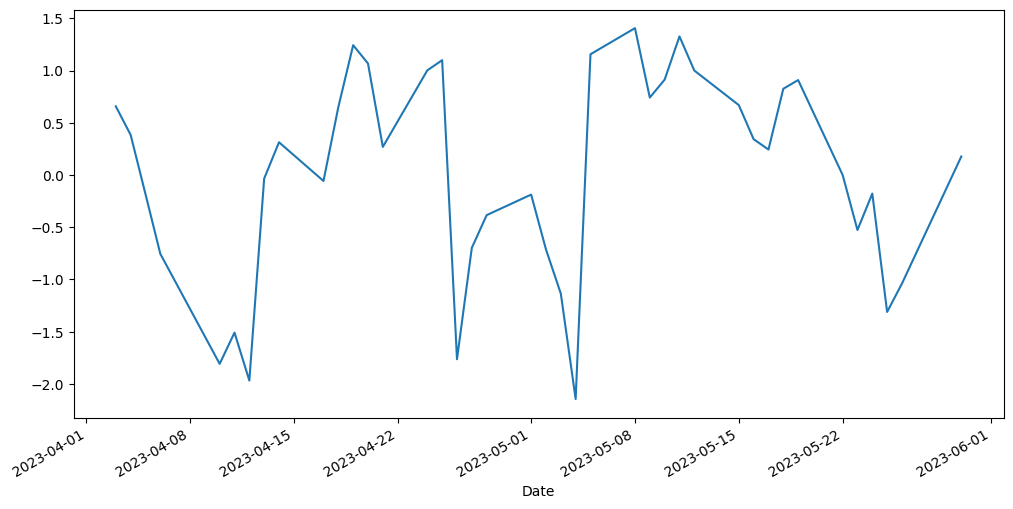

In [14]:

spread_mean = spread.mean()
spread_std = spread.std()
zscore = (spread-spread_mean)/spread_std
zscore.plot(figsize = (12,6))

In [15]:
# removing instial na values
first_valid_idx = zscore.first_valid_index()
zscore = zscore[first_valid_idx:]

In [16]:
len(zscore)

40

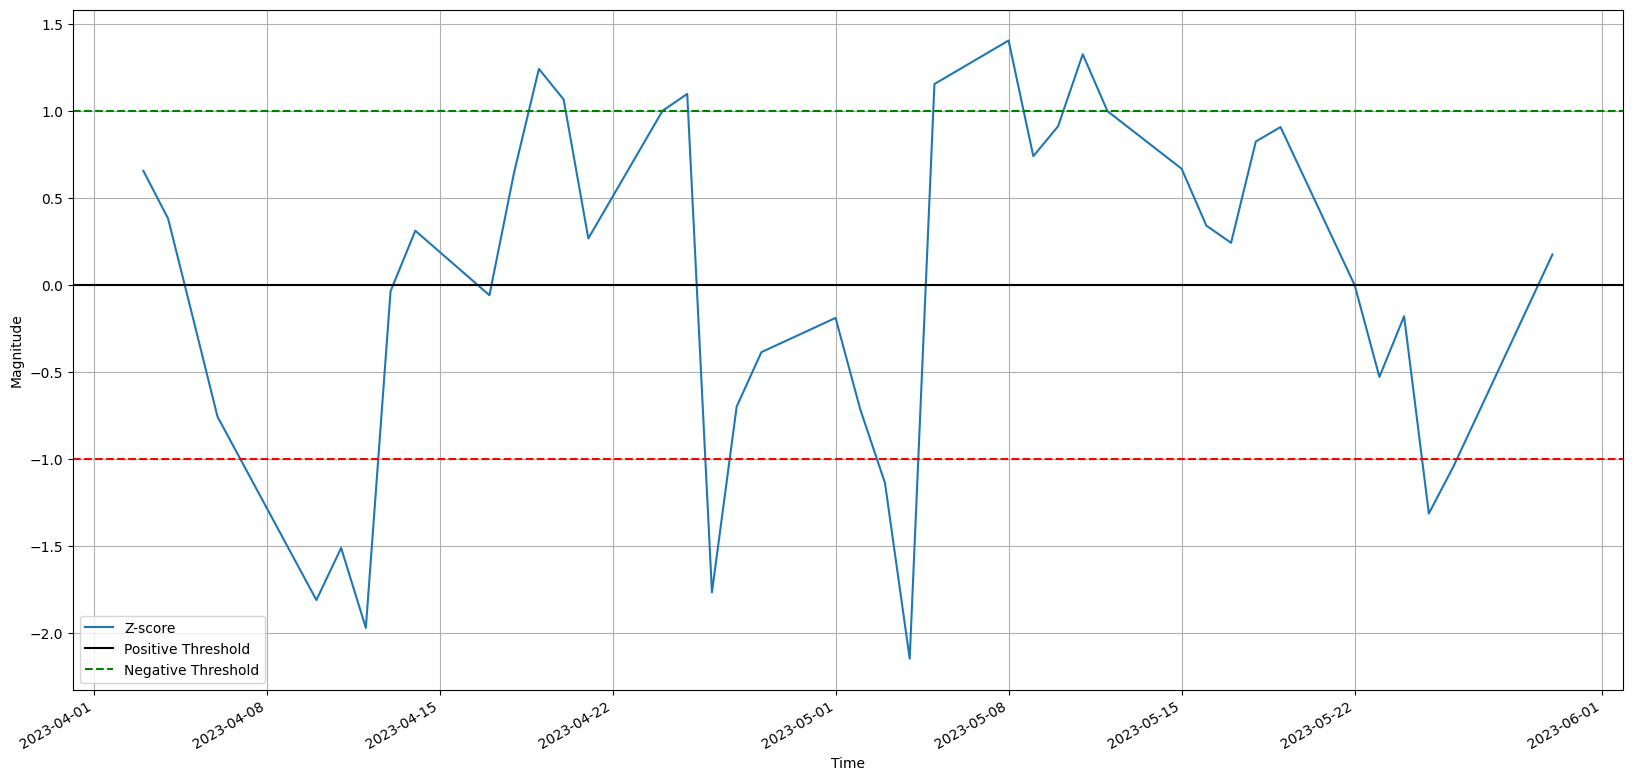

In [17]:
plt.figure(figsize=(20,10))
zscore.plot()
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.axhline(zscore.mean(), color = 'black')
plt.axhline(1, color = 'green', linestyle = '--') # Note 1 is randomly chosen
plt.axhline(-1, color = 'red', linestyle = '--') # Note -1 is randomly chosen
plt.legend(['Z-score', 'Positive Threshold', 'Negative Threshold'], loc='lower left')
plt.grid(True)
plt.show()

In [18]:
# set threshold for entry and exit position
entry_threshold = 2.0
exit_threshold = 1.0
# intitate the daily position as zero
stock1_position = pd.Series(data=0, index=zscore.index)
stock2_position = pd.Series(data=0, index=zscore.index)
# generate daily entry and exit signal for each stock
for i in range(1,len(zscore)):
    # zcore <-2 and no existing long position for stock 1
    if zscore[i] < -entry_threshold and stock1_position[i-1] == 0:
        stock1_position[i] = 1 # long stock 1
        stock2_position[i] = -1 # short Stock 2
    # zscore >2 and no existing short position for stock 2
    elif zscore[i] > entry_threshold and stock2_position[i-1]==0:
        stock1_position[i] = -1 # short stock 1
        stock2_position[i] = 1 # long stock 2
    # -1<zscore<1
    elif abs(zscore[i]) < exit_threshold:
        stock1_position[i] = 0 # exit existing position
        stock1_position[i] = 0
    # -2 < zscore<-1 or 1<zscore<2
    else:
        stock1_position[i] = stock1_position[i-1] # maintain existing position
        stock2_position[i] = stock2_position[i-1]

        

// SET entry_threshold to 2.0
// SET exit_threshold to 1.0
// CREATE series dataframe fro stock1_position with zcore index as index for series
// CREATE series dataframe fro stock2_position with zcore index as index for series
// FOR LOOP i in RANGE(1, LEN(zscore)):
    // IF zscore[i] below  -entry_threshold and stock1_position is equal to 0:
        // LONG stock 1
        // SHORT stock 2
    // ELSE IF zscore[i] above entry_threshold and stock2_position is equal to 0:
        // short stock 1
        // long stock 2
    // ELSE IF zcore above -1 and below 1:
        // exit existing position
    // ELSE  : When zscore is above -2 and zscore below -1 or zscore is above 1 and zscore is below 2
        // Maintain existing Position
        
        
        
        
    
